# Multiple Linear Regression (MLR) of Synthetic Data with Outliers

In [7]:
# Essential packages
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import numpy as np

# Statsmodels packages
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

# Scikit-learn packages
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, ARDRegression, Lasso, LassoLars, ElasticNet, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Load data
X_train = np.load("../data/X_train.npy")
y_train = np.load("../data/y_train.npy")

## Outlier Removal

Iteration 1: Detected 4 outliers.
Iteration 2: Detected 8 outliers.
Iteration 3: Detected 6 outliers.
Iteration 4: Detected 8 outliers.
Iteration 5: Detected 8 outliers.
Iteration 6: Detected 5 outliers.
Iteration 7: Detected 7 outliers.
Iteration 8: Detected 3 outliers.
Iteration 9: Detected 1 outliers.
Iteration 10: Detected 2 outliers.
Iteration 11: Detected 0 outliers.
No more outliers detected. Stopping.


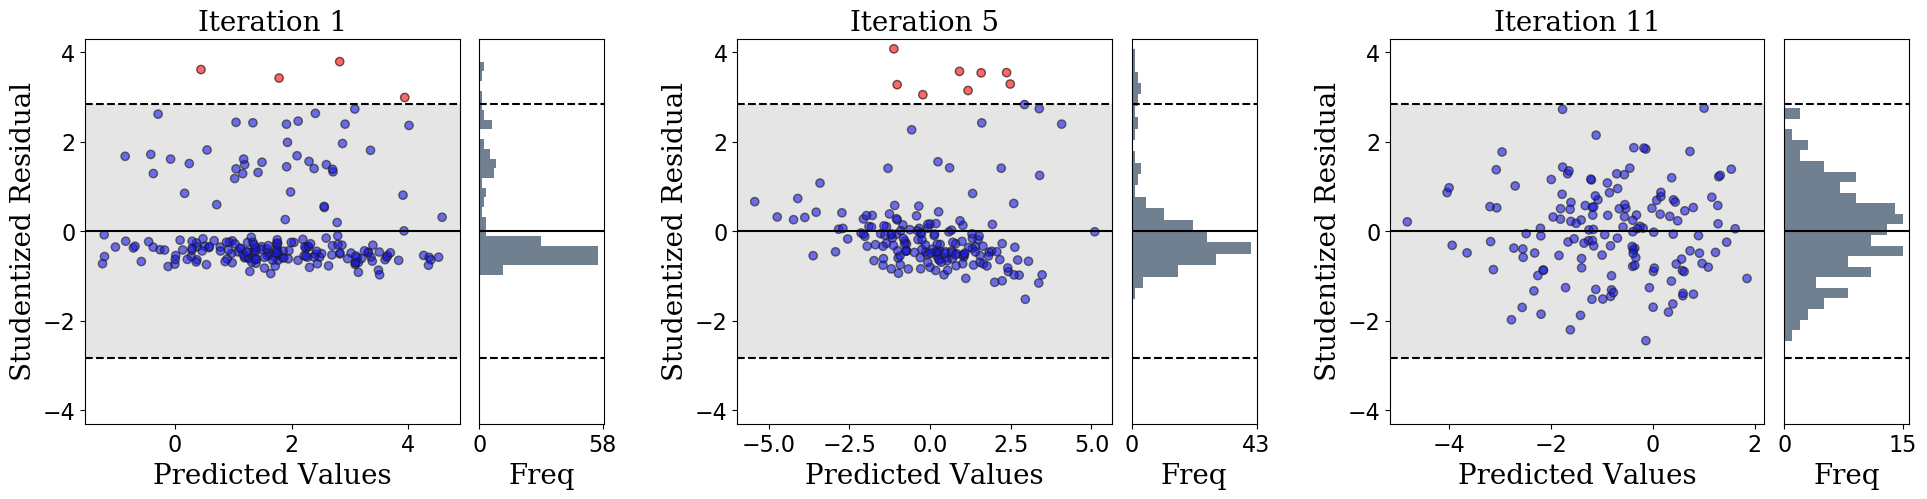

Deleted a total of 52 outliers.


In [24]:
def CreateOutlierRemovalPlots(sse_list, outliers_removed_list, residuals_list):
    iterations = np.arange(1, len(sse_list) + 1)

    # Plot 1: SSE over iterations
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(iterations, sse_list, marker='o')
    plt.title("SSE vs Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.grid(True)

    # Plot 2: Number of Outliers Removed at each iteration
    plt.subplot(1, 2, 2)
    plt.plot(iterations, outliers_removed_list, marker='o', color='red')
    plt.title("Number of Outliers Removed vs Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Number of Outliers Removed")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot 3: Studentized Residuals over Iterations
    nrows = 2
    ncols = int(np.ceil(len(residuals_list) / nrows))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))
    axes = axes.ravel() # Flatten the axes array to make it easier to index

    # Iterate over each iteration and plot the residuals
    for i in enumerate(residuals_list):
        axes[i].hist(residuals, bins=50, alpha=0.7, label=f"Iteration {i+1}")
        axes[i].set_title(f"Iteration {i+1}")
        axes[i].set_xlabel("Studentized Residuals")
        axes[i].set_ylabel("Frequency")
        axes[i].legend()
        axes[i].grid(True)

    # Remove any empty subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust the layout
    plt.tight_layout()
    plt.show()

    return

def ScatterPlot(mask, y_train):
    plt.scatter(range(len(y_train)), y_train, c=mask,
                cmap='coolwarm', label='Inliers')
    plt.xlabel("Sample index")
    plt.ylabel("Studentized Residuals")
    plt.show()

    return


def IterativeOutlierRemoval(X, y, threshold=2.839, desired_iterations=[1, 5, 11], tol=0.01):
    # Add constant for the intercept
    X_with_const = sm.add_constant(X)
    previous_sse = float('inf')

    # Lists to track metrics for each iteration
    sse_list = []
    tot_outliers = []
    residuals_list = []
    outliers_removed_list = []

    iteration = 0

    num_desired_iterations = len(desired_iterations)

    # Plot Setup
    total_cols = 3 * num_desired_iterations 
    fig = plt.figure(figsize=(25, 5)) 

    # Create GridSpec with columns for scatter plots and histograms
    gs = GridSpec(1, total_cols, width_ratios=[3, 1, 0.75] * num_desired_iterations)  # The 3rd value (0.3) is space between blocks
    plt.subplots_adjust(wspace=0.1) 
    
    while True:
        # Fit the linear regression model
        model = sm.OLS(y, X_with_const).fit()

        # Calculate studentized residuals
        influence = OLSInfluence(model)
        studentized_residuals = influence.resid_studentized_external

        # Identify outliers based on studentized residuals
        outliers = np.abs(studentized_residuals) > threshold
        num_outliers = np.sum(outliers)
        tot_outliers.append(num_outliers)
        print(f"Iteration {iteration + 1}: Detected {num_outliers} outliers.")

        # Plot the specified iterations in each subplot
        if iteration + 1 in desired_iterations:
            # Get the index of the subplot corresponding to this iteration
            plot_index = desired_iterations.index(iteration + 1)

            # Create scatter plot in the left axis of each iteration (we skip the spacer column)
            ax_scatter = fig.add_subplot(gs[0, 3 * plot_index])
            ax_scatter.scatter(model.fittedvalues, studentized_residuals, 
                               c=['red' if outlier else 'blue' for outlier in outliers], 
                               alpha=0.6, edgecolor='k')

            # Shadow inside the region of confidence
            ax_scatter.axhspan(-threshold, threshold, facecolor='grey', alpha=0.2)

            # Threshold and baseline lines
            ax_scatter.axhline(y=0, linestyle='-', color='black')
            ax_scatter.axhline(y=threshold, linestyle='--', color='black')
            ax_scatter.axhline(y=-threshold, linestyle='--', color='black')
            ax_scatter.set_ylim(-4.3, 4.3)

            # Explicity-ticks
            y_ticks = np.arange(-4, 5, 2)  
            ax_scatter.set_yticks(y_ticks)

            ax_scatter.xaxis.set_tick_params(labelsize=16)
            ax_scatter.yaxis.set_tick_params(labelsize=16)

            # Font customization
            ax_scatter.set_xlabel("Predicted Values", fontsize=20, family='DejaVu Serif')
            ax_scatter.set_ylabel("Studentized Residual", fontsize=20, family='DejaVu Serif')
            ax_scatter.set_title(f"Iteration {iteration + 1}", fontsize=20, family='DejaVu Serif')

            # Create Histogram plot (next to scatter, no space in between)
            ax_hist = fig.add_subplot(gs[0, 3 * plot_index + 1])
            ax_hist.hist(studentized_residuals, bins=22, orientation='horizontal', color='slategrey', alpha=1)
            ax_hist.axhline(y=threshold, linestyle='--', color='black')
            ax_hist.axhline(y=-threshold, linestyle='--', color='black')
            ax_hist.axhline(y=0, linestyle='-', color='black')
            ax_hist.set_ylim(-4.3, 4.3)

            # Font customization
            ax_hist.set_xlabel("Freq", fontsize=20, family='DejaVu Serif')

            # Set x-ticks for the histogram: 0 and the maximum value
            xlim = ax_hist.get_xlim() 
            ax_hist.set_xticks([int(0), int(xlim[1])])  

            # Remove y-ticks completely from the histogram
            ax_hist.set_yticks([])
            ax_hist.xaxis.set_tick_params(labelsize=16)

            # Tighten the layout between scatter plot and histogram
            ax_hist.set_xlim([0, ax_hist.get_xlim()[1]]) 

        if num_outliers == 0:
            print("No more outliers detected. Stopping.")
            break

        # Store metrics for plotting
        sse = np.sum((y - model.fittedvalues) ** 2)
        sse_list.append(sse)
        outliers_removed_list.append(num_outliers)
        residuals_list.append(studentized_residuals)

        # Remove outliers
        X_with_const = X_with_const[~outliers]
        y = y[~outliers]

        # Refit the model and calculate new SSE
        sse = np.sum((y - model.fittedvalues[~outliers]) ** 2)

        # Stopping condition based on SSE improvement
        if abs(previous_sse - sse) < tol:
            print(f"SSE change below tolerance ({tol}). Stopping at iteration {iteration + 1}.")
            break

        previous_sse = sse  # Update SSE for the next iteration
        iteration += 1
            
    plt.savefig('OutlierRemoval.pdf', bbox_inches='tight')
    plt.show()
    
    X_train_cleaned = X_with_const[:, 1:]  # Remove the constant column for final dataset
    y_train_cleaned = y
    print(f"Deleted a total of {np.sum(tot_outliers)} outliers.")

    return X_train_cleaned, y_train_cleaned

# Perform outlier removal
X_train_cleaned, y_train_cleaned = IterativeOutlierRemoval(X_train, y_train)

## Train-Test Split and Standardization

In [3]:
def Standardize(vector):
  mu = np.mean(vector, axis=0)
  sigma = np.std(vector, axis=0)
  standardized_vector = (vector - mu) / sigma

  return standardized_vector, mu, sigma

def Destandardize(standardized_vector, mu, sigma):
  return standardized_vector * sigma + mu

# Standardize cleaned data (without outliers)
X_standardized, mu_X, sigma_X = Standardize(X_train_cleaned)

# Split data into training and testing sets randomly
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y_train_cleaned, train_size=0.75, random_state=120)

# Set to True to train on all outlier free samples, otherwise use False
if True:
  X_train = X_standardized
  y_train = y_train_cleaned

## Exploratory Data Analysis

Breusch-Pagan Test:
  LM Statistic: 3.771283
  LM p-value: 0.582793
  F-value: 0.742601
  F p-value: 0.592803

White Test:
  White Test p-value: 0.346034



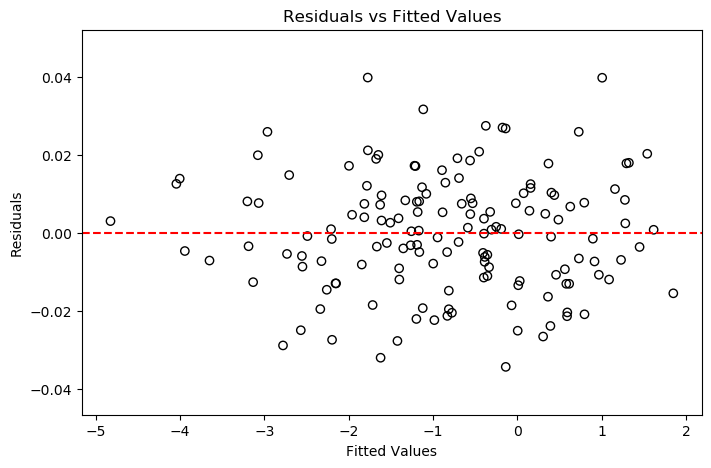

In [63]:
def TestHeteroskedasticity(X, y):
    # Fit linear model
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    # Perform Breusch-Pagan test
    lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(model.resid, model.model.exog)

    # Perform White test
    white_test_results = het_white(model.resid, model.model.exog)
    white_test_pvalue = white_test_results[1]

    # Print test results
    print("Breusch-Pagan Test:")
    print(f"  LM Statistic: {lm:.6f}")
    print(f"  LM p-value: {lm_pvalue:.6f}")
    print(f"  F-value: {fvalue:.6f}")
    print(f"  F p-value: {f_pvalue:.6f}\n")

    print("White Test:")
    print(f"  White Test p-value: {white_test_pvalue:.6f}\n")

    plt.figure(figsize=(8, 5))
    plt.scatter(model.fittedvalues, model.resid, edgecolors='k', facecolors='none')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.show()

TestHeteroskedasticity(X_train_cleaned, y_train_cleaned)

## Test for Optimal Number of Folds in Cross Validation


Testing Ridge
Testing with 2 folds
Testing with 3 folds
Testing with 4 folds
Testing with 5 folds
Testing with 6 folds
Testing with 7 folds
Testing with 8 folds
Testing with 9 folds
Testing with 10 folds
Testing with 11 folds
Testing with 12 folds
Testing with 13 folds
Testing with 14 folds
Testing with 15 folds
Testing with 16 folds
Testing with 17 folds
Testing with 18 folds
Testing with 19 folds
Testing with 20 folds

Testing Lasso
Testing with 2 folds
Testing with 3 folds
Testing with 4 folds
Testing with 5 folds
Testing with 6 folds
Testing with 7 folds
Testing with 8 folds
Testing with 9 folds
Testing with 10 folds
Testing with 11 folds
Testing with 12 folds
Testing with 13 folds
Testing with 14 folds
Testing with 15 folds
Testing with 16 folds
Testing with 17 folds
Testing with 18 folds
Testing with 19 folds
Testing with 20 folds


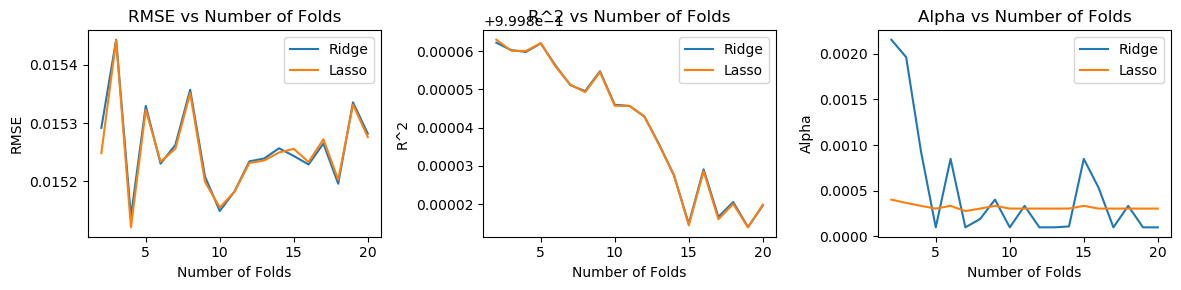

In [4]:
def TestNumberOfFolds(X, y, models, param_grids, folds_list):
    # Dictionary to store results
    results = {}

    # Iterate over each model
    for model_name, model, param_grid in zip(models.keys(), models.values(), param_grids):
        print(f"\nTesting {model_name}")
        rmse_values = []
        r2_values = []
        alpha_values = []

        # Test different fold values
        for n_folds in folds_list:
            print(f"Testing with {n_folds} folds")
            # Initialize GridSearchCV
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                scoring=['neg_mean_squared_error', 'r2'],
                cv=n_folds,
                refit='neg_mean_squared_error',
                verbose=0,
                n_jobs = -1
            )

            # Fit the GridSearchCV to find the best parameter(s)
            grid_search.fit(X, y)

            # Extract the best parameter(s)
            best_params = grid_search.best_params_
            best_index = grid_search.best_index_

            # Get metrics for plot
            mean_rmse = np.sqrt(-grid_search.cv_results_['mean_test_neg_mean_squared_error'][best_index])
            mean_r2 = grid_search.cv_results_['mean_test_r2'][best_index]
            alpha = list(best_params.values())[0]

            # Append results
            rmse_values.append(mean_rmse)
            r2_values.append(mean_r2)
            alpha_values.append(alpha)

        # Store results in dictionary
        results[model_name] = {'folds': folds_list, 'rmse': rmse_values, 'r2': r2_values, 'alpha': alpha_values}

    # Plot the results for each model
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))

    # RMSE Plot
    ax[0].set_title('RMSE vs Number of Folds')
    ax[0].set_xlabel('Number of Folds')
    ax[0].set_ylabel('RMSE')
    for model_name in results:
        ax[0].plot(results[model_name]['folds'], results[model_name]['rmse'], label=model_name)
    ax[0].legend()

    # R^2 Plot
    ax[1].set_title('R^2 vs Number of Folds')
    ax[1].set_xlabel('Number of Folds')
    ax[1].set_ylabel('R^2')
    for model_name in results:
        ax[1].plot(results[model_name]['folds'], results[model_name]['r2'], label=model_name)
    ax[1].legend()

    # Params
    ax[2].set_title('Alpha vs Number of Folds')
    ax[2].set_xlabel('Number of Folds')
    ax[2].set_ylabel('Alpha')
    for model_name in results:
        ax[2].plot(results[model_name]['folds'], results[model_name]['alpha'], label=model_name)
    ax[2].legend()

    plt.tight_layout()
    plt.show()

# Define the models and parameter grids
models = {
    'Ridge': Ridge(fit_intercept=True),
    'Lasso': Lasso(fit_intercept=True)
    #'Bayesian Ridge': BayesianRidge(fit_intercept=True)
}

param_grids = [
    {'alpha': np.logspace(-4, 0, 100)},  # Ridge
    {'alpha': np.logspace(-4, 0, 100)},  # Lasso
    {
        'alpha_init': np.linspace(0.1, 0.5, 10),
        'alpha_1': np.logspace(-6, 0, 3),
        'alpha_2': np.logspace(-6, 0, 3),
        'lambda_1': np.logspace(-6, 0, 3),
        'lambda_2': np.logspace(-6, 0, 3)
    } # Bayesian Ridge
]

# List of fold values to test
folds_list = np.arange(2, 21, 1)

TestNumberOfFolds(X_train, y_train, models, param_grids, folds_list)

## Hyperparameter Tuning and Model Training

In [ ]:
def CrossValidationTuning(X, y, model, param_grid, n_folds=5):
    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=['neg_mean_squared_error', 'r2'],
        cv=n_folds,
        refit='neg_mean_squared_error',
        verbose=0
    )

    # Fit the GridSearchCV to find the best parameter(s)
    grid_search.fit(X, y)

    # Extract the best parameter(s) and estimator
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_index = grid_search.best_index_

    # Print best hyperparameter(s) found
    print(f"Best Hyperparameters: {best_params}\n")

    # Print the metrics with respective std dev across folds
    mean_rmse = np.sqrt(-grid_search.cv_results_['mean_test_neg_mean_squared_error'][best_index])
    std_rmse = np.sqrt(grid_search.cv_results_['std_test_neg_mean_squared_error'][best_index])
    mean_r2 = grid_search.cv_results_['mean_test_r2'][best_index]
    std_r2 = grid_search.cv_results_['std_test_r2'][best_index]

    print(f"-> Best Model's Performance for {n_folds}-Fold CV")
    print(f"Cross-Validated RMSE: {mean_rmse}")
    print(f"RMSE STD Deviation: {std_rmse}")
    print(f"Cross-Validated R^2: {mean_r2}")
    print(f"R^2 STD Deviation: {std_r2}\n")

    return best_model

def RidgeModelTuning(X, y):
  param_grid = {
    'alpha': np.logspace(-4, 1, 100)
  }

  print("=== Ridge Model ===")
  target_model = Ridge(fit_intercept=True)
  tuned_model = CrossValidationTuning(X, y, target_model, param_grid)

  return tuned_model

def BayesianRidgeModelTuning(X, y):
    param_grid = {
        'alpha_init': np.linspace(0.01, 1.0, 100),
        'alpha_1': np.logspace(-6, 0, 3),
        'alpha_2': np.logspace(-6, 0, 3),
        'lambda_1': np.logspace(-6, 0, 3),
        'lambda_2': np.logspace(-6, 0, 3)
    }

    print("=== Bayesian Ridge Model ===")
    target_model = BayesianRidge(fit_intercept=True)
    tuned_model = CrossValidationTuning(X, y, target_model, param_grid)
    tuned_model.fit(X,y)

    return tuned_model

def ARDRegressionModelTuning(X, y):
    param_grid = {
        'alpha_1': np.logspace(-6, 0, 10),
        'alpha_2': np.logspace(-6, 0, 10),
        'lambda_1': np.logspace(-6, 0, 10),
        'lambda_2': np.logspace(-6, 0, 10)
    }

    print("=== ARD Regression Model ===")
    target_model = ARDRegression(fit_intercept=True)
    tuned_model = CrossValidationTuning(X, y, target_model, param_grid)

    return tuned_model

def LassoModelTuning(X, y):
  param_grid = {
    'alpha': np.logspace(-4, 0, 100)
  }

  print("=== Lasso Model ===")
  target_model = Lasso(fit_intercept=True)
  tuned_model = CrossValidationTuning(X, y, target_model, param_grid)

  return tuned_model

def LarsLassoModelTuning(X, y):
    param_grid = {
        'alpha': np.logspace(-4, 0, 100)
    }

    print("=== LarsLasso Model ===")
    target_model = LassoLars(fit_intercept=True)
    tuned_model = CrossValidationTuning(X, y, target_model, param_grid)

    return tuned_model

def ElasticNetModelTuning(X, y):
  param_grid = {
    'alpha': np.logspace(-4, 1, 1000),
    'l1_ratio': np.linspace(0.1, 0.9, 100), # L1 ratio: 0 (Ridge) to 1 (Lasso)
  }

  print("=== ElasticNet Model ===")
  target_model = ElasticNet(tol=1e-5)
  tuned_model = CrossValidationTuning(X, y, target_model, param_grid)

  return tuned_model


def SVRModelTuning(X, y):
  param_grid = {
    'C': np.logspace(-2, 3, 100),
    'epsilon': np.linspace(0, 1, 100)
  }

  print("=== SVR Model ===")
  target_model = SVR(kernel='linear')
  tuned_model = CrossValidationTuning(X, y, target_model, param_grid)

  return tuned_model

def HuberModelTuning(X, y):
    param_grid = {
        'epsilon': np.linspace(1, 2, 10),
        'alpha': np.logspace(-4, 1, 100)
    }

    print("=== Huber Regression Model ===")
    target_model = HuberRegressor()
    tuned_model = CrossValidationTuning(X, y, target_model, param_grid)
    tuned_model.fit(X,y)

    return tuned_model

def WLSModel(X, y):
    X_with_constant = sm.add_constant(X)
    ols_model = sm.OLS(y, X_with_constant).fit()
    weights = 1 / np.square(ols_model.resid)
    wls_model = sm.WLS(y, X_with_constant, weights=weights).fit()

    print("=== WLS Model ===")
    print("WLS Summary:", wls_model.summary())

    return wls_model

def GLSModel(X, y):
    X_with_constant = sm.add_constant(X)
    ols_model = sm.OLS(y, X_with_constant).fit()
    sigma = np.diag(ols_model.resid**2) # Homoskedastic?
    gls_model = sm.GLS(y, X_with_constant, sigma=sigma).fit()

    print("=== GLS Model ===")
    print(gls_model.summary())

    return gls_model

# Baseline OLS model
ols_model = LinearRegression().fit(X_train, y_train)

# WLS linear model
#wls_model = WLSModel(X_train, y_train)

# GLS linear model
#gls_model = GLSModel(X_train, y_train)

# Perform CV on target models and extract the best hyperparameters
tuned_ridge_model = RidgeModelTuning(X_train, y_train)
tuned_bayesian_model = BayesianRidgeModelTuning(X_train, y_train)
#tuned_ard_model = ARDRegressionModelTuning(X_train, y_train)
tuned_lasso_model = LassoModelTuning(X_train, y_train)
#tuned_lars_model = LarsLassoModelTuning(X_train, y_train)
#tuned_elasticnet_model = ElasticNetModelTuning(X_train, y_train)
#tuned_svr_model = SVRModelTuning(X_train, y_train)
#tuned_huber_model = HuberModelTuning(X_train, y_train)

## Performance Evaluation of the Best Models

In [ ]:
def PerformanceMetrics(tuned_model, X_test, y_test):
  # Predict on the test data
  y_test_pred = tuned_model.predict(X_test)

  # Evaluate performance
  test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
  test_mae = mean_absolute_error(y_test, y_test_pred)
  test_r2 = r2_score(y_test, y_test_pred)
  test_sse = np.sum((y_test - y_test_pred) ** 2)

  # print(f"Intercept: {tuned_model.intercept_}")
  # print(f"Coefficients: {tuned_model.coef_}\n")

  print("-> Error Metrics")
  print(f" R^2: {test_r2:.6f}")
  print(f"RMSE: {test_rmse:.6f}")
  print(f" MAE: {test_mae:.6f}")
  print(f" SSE: {test_sse:.6f}\n")

  return

print("=== OLS Model ===")
PerformanceMetrics(ols_model, X_standardized, y_train_cleaned)

#print("=== WLS Model ===")
#PerformanceMetrics(wls_model, sm.add_constant(X_standardized), y_train_cleaned)

#print("=== GLS Model ===")
#PerformanceMetrics(gls_model, sm.add_constant(X_standardized), y_train_cleaned)

print("=== Ridge Model ===")
PerformanceMetrics(tuned_ridge_model, X_standardized, y_train_cleaned)

print("=== BayesianRidge Model ===")
PerformanceMetrics(tuned_bayesian_model, X_standardized, y_train_cleaned)

#print("=== ARD Regression Model ===")
#PerformanceMetrics(tuned_ard_model, X_standardized, y_train_cleaned)

print("=== Lasso Model ===")
PerformanceMetrics(tuned_lasso_model, X_standardized, y_train_cleaned)

#print("=== LarsLasso Model ===")
#PerformanceMetrics(tuned_lars_model, X_standardized, y_train_cleaned)

#print("=== ElasticNet Model ===")
#PerformanceMetrics(tuned_elasticnet_model, X_standardized, y_train_cleaned)

#print("=== SVR Model ===")
#PerformanceMetrics(tuned_svr_model, X_standardized, y_train_cleaned)

#print("=== Huber Model ===")
#PerformanceMetrics(tuned_huber_model, X_standardized, y_train_cleaned)

## Save Best Model's Prediction

In [ ]:
# Load data
X_total = np.load("./data/X_test.npy")
X_total_standardized, _, _ = Standardize(X_total)

# Predict
best_model = tuned_bayesian_model
y_pred = best_model.predict(X_total_standardized)
np.save('./y_pred.npy', y_pred)

In [ ]:
y_pred_old = np.load("./data/y_pred_old.npy")

print(f"MAE: {np.sum(np.abs(y_pred_old - y_pred)) / len(y_pred)}")
print(f"SSE: {np.sum((y_pred_old - y_pred)**2)}\n")

pd.set_option('display.max_rows', None)

comparison_df = pd.DataFrame({
    'y_pred_old': y_pred_old,
    'y_pred_new': y_pred
})

print(comparison_df)